https://rmizutaa.hatenablog.com/entry/2020/09/26/114344
https://github.com/tslearn-team/tslearn/tree/775daddb476b4ab02268a6751da417b8f0711140

In [1]:
DAY = "20200925"

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/My\ Drive/Kaggle/

Mounted at /content/drive
Bengali.AI_Handwritten_Grapheme_Classification
global-wheat-detection
IEEE
Ion_Switching_University_of_Liverpool
kaggle.json
m5-forecasting-accuracy
Melanoma_classification
osic-pulmonary-fibrosis-progression
PANDA
Plant_Pathology_2020
Pneumothorax_Segmentation
utils


In [ ]:
%%time
#Set Path

_PATH="/content/drive/'My Drive'/Kaggle/osic-pulmonary-fibrosis-progression"

! ls -all $_PATH
! chmod -R 777 $_PATH/input/
! mkdir -p $_PATH/output/$DAY

total 12
drwx------ 5 root root 4096 Jul  9 15:59 input
drwx------ 3 root root 4096 Sep  5 15:55 output
drwx------ 2 root root 4096 Sep  5 15:55 script
CPU times: user 25.3 ms, sys: 20.1 ms, total: 45.3 ms
Wall time: 9.07 s


In [3]:
!sudo python3 -m pip install tslearn

     |████████████████████████████████| 778kB 2.7MB/s 


In [4]:
import albumentations
import copy
import cv2

#from efficientnet_pytorch import model as enet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image

import random

import sklearn
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,PowerTransformer
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

from skimage import exposure

import time
from tqdm import notebook as tqdm
import tslearn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler

print("PyTorch Version: ",torch.__version__)
print(f"sklern: {sklearn.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)#

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


PyTorch Version:  1.6.0+cu101
sklern: 0.22.2.post1
cpu


In [5]:
random_seed = 42

def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(random_seed)

In [6]:
data_dir = "/content/drive/My Drive/Kaggle/osic-pulmonary-fibrosis-progression/input/"
output_dir = f"/content/drive/My Drive/Kaggle/osic-pulmonary-fibrosis-progression/output/{DAY}/"

df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
sample = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))


In [ ]:
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


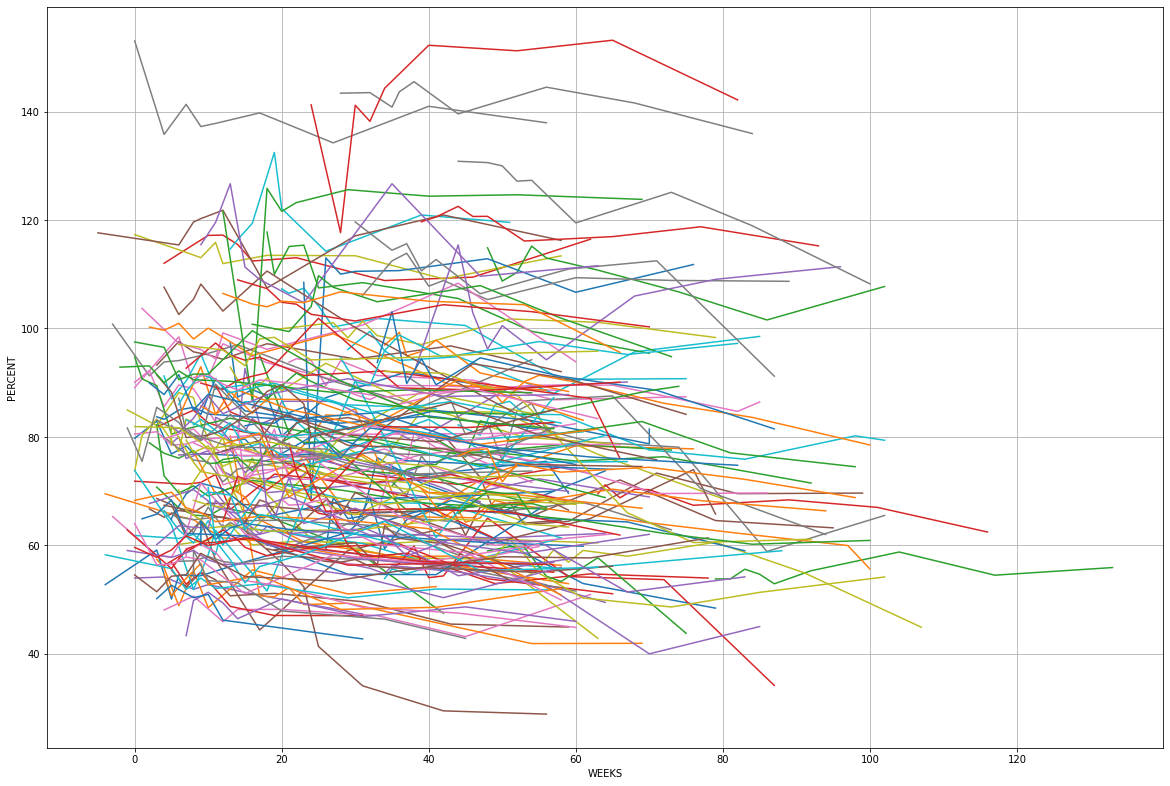

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 30

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
for pt_id in (set(df_train.Patient)):
  tmp_df = df_train[df_train.Patient == pt_id]
  ax.plot(tmp_df.Weeks, tmp_df.Percent)

ax.set_xlabel('WEEKS')
ax.set_ylabel('PERCENT')
ax.grid(True)
plt.show()

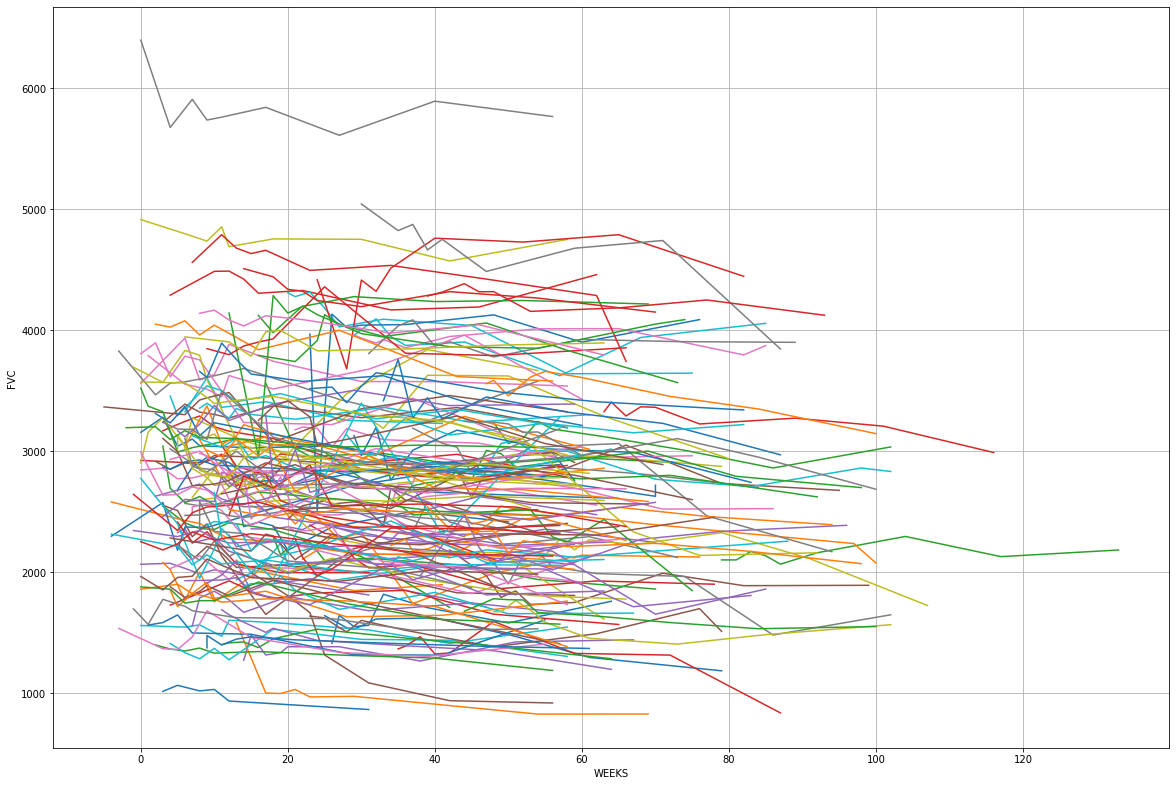

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 30

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
for pt_id in (set(df_train.Patient)):
  tmp_df = df_train[df_train.Patient == pt_id]
  ax.plot(tmp_df.Weeks, tmp_df.FVC)

ax.set_xlabel('WEEKS')
ax.set_ylabel('FVC')
ax.grid(True)
plt.show()

In [9]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.barycenters import dtw_barycenter_averaging

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [25]:
points=[]
ax = fig.add_subplot(2,1,1)
for pt_id in df_train.Patient.unique():
  tmp_df = df_train[df_train.Patient == pt_id]
  points.append(np.array(tmp_df[["Weeks","Percent"]]))
points = to_time_series_dataset(points)
points

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


array([[[-4.        , 58.25364872],
        [ 5.        , 55.71212884],
        [ 7.        , 51.86210367],
        ...,
        [41.        , 51.93759436],
        [57.        , 51.76144942],
        [        nan,         nan]],

       [[ 8.        , 85.28287818],
        [ 9.        , 84.11781154],
        [11.        , 90.7586914 ],
        ...,
        [45.        , 78.99151831],
        [60.        , 74.89048374],
        [        nan,         nan]],

       [[ 0.        , 94.72467197],
        [ 1.        , 90.69154657],
        [ 3.        , 89.45472145],
        ...,
        [37.        , 66.51968165],
        [54.        , 67.70273177],
        [        nan,         nan]],

       ...,

       [[ 6.        , 76.67249325],
        [11.        , 76.91085333],
        [13.        , 77.66566026],
        ...,
        [47.        , 68.05180359],
        [        nan,         nan],
        [        nan,         nan]],

       [[17.        , 79.25890279],
        [18.        , 66.81

In [106]:
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=1,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=100,
                          random_state=42)

In [107]:
pred = dba_km.fit_predict(points)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.0s finished


3119.667 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.0s finished


2445.172 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.0s finished


2243.337 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.0s finished


2029.841 --> 1984.746 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.0s finished


1972.974 --> 1969.761 --> 1969.761 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:    0.0s finished


In [108]:
pred

array([0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 1, 0, 1, 1, 2, 0, 2, 2,
       2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 0, 2, 2,
       2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 2, 0, 2, 0, 1, 1, 1,
       1, 2, 1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 1, 2,
       2, 2, 2, 0, 2, 1, 2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 0,
       0, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 1,
       0, 2, 2, 1, 0, 0, 1, 2, 0, 1, 0, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2, 0,
       0, 1, 2, 0, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0])

In [109]:
cluster_df = pd.DataFrame({"pt_id": df_train.Patient.unique(), "cluster":pred})
cluster_df.to_csv(output_dir + f"{DAY}_osci_clustering.csv", index=False)
cluster_df

,pt_id,cluster
0,ID00007637202177411956430,0
1,ID00009637202177434476278,2
2,ID00010637202177584971671,2
3,ID00011637202177653955184,2
4,ID00012637202177665765362,2
...,...,...
171,ID00419637202311204720264,0
172,ID00421637202311550012437,2
173,ID00422637202311677017371,2
174,ID00423637202312137826377,0


In [110]:
c0=[]
c1=[]
c2=[]
c3=[]

for pt_id,  c in zip(df_train.Patient.unique(), pred):
    tmp_df = df_train[df_train.Patient == pt_id]
    if c==0:
        c0.append(np.array(tmp_df[["Weeks","Percent"]]))
    elif c==1:
        c1.append(np.array(tmp_df[["Weeks","Percent"]]))
    elif c==2:
        c2.append(np.array(tmp_df[["Weeks","Percent"]]))
    elif c==3:
        c3.append(np.array(tmp_df[["Weeks","Percent"]]))

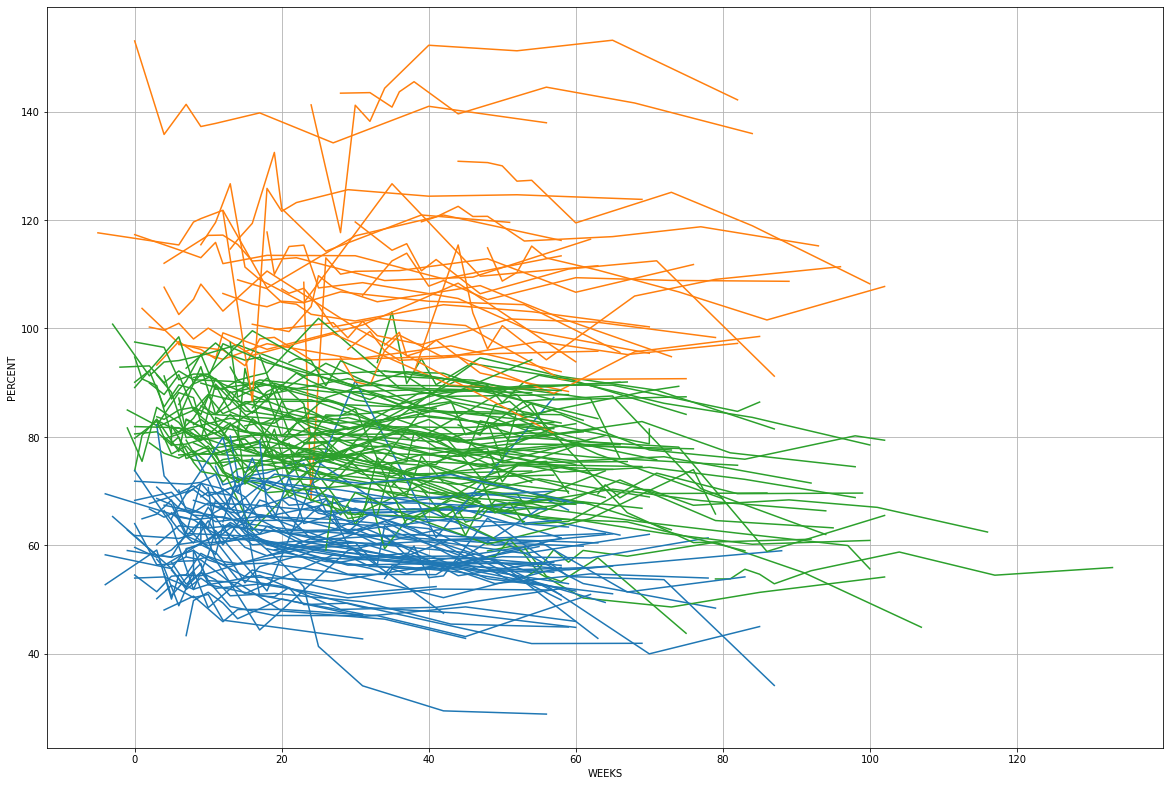

In [111]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 30

import matplotlib
colors = list(matplotlib.colors.TABLEAU_COLORS.items())

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
for pt_id, c in zip(df_train.Patient.unique(), pred):
  tmp_df = df_train[df_train.Patient == pt_id]
  ax.plot(tmp_df.Weeks, tmp_df.Percent, color=colors[c][1])

ax.set_xlabel('WEEKS')
ax.set_ylabel('PERCENT')
ax.grid(True)
plt.show()

In [112]:
dba_c0=dtw_barycenter_averaging(c0)
dba_c1=dtw_barycenter_averaging(c1)
dba_c2=dtw_barycenter_averaging(c2)
dba_c3=dtw_barycenter_averaging(c3)

/usr/local/lib/python3.6/dist-packages/tslearn/barycenters.py:286: RuntimeWarning: invalid value encountered in double_scalars
  cost /= weights.sum()


IndexError: ignored

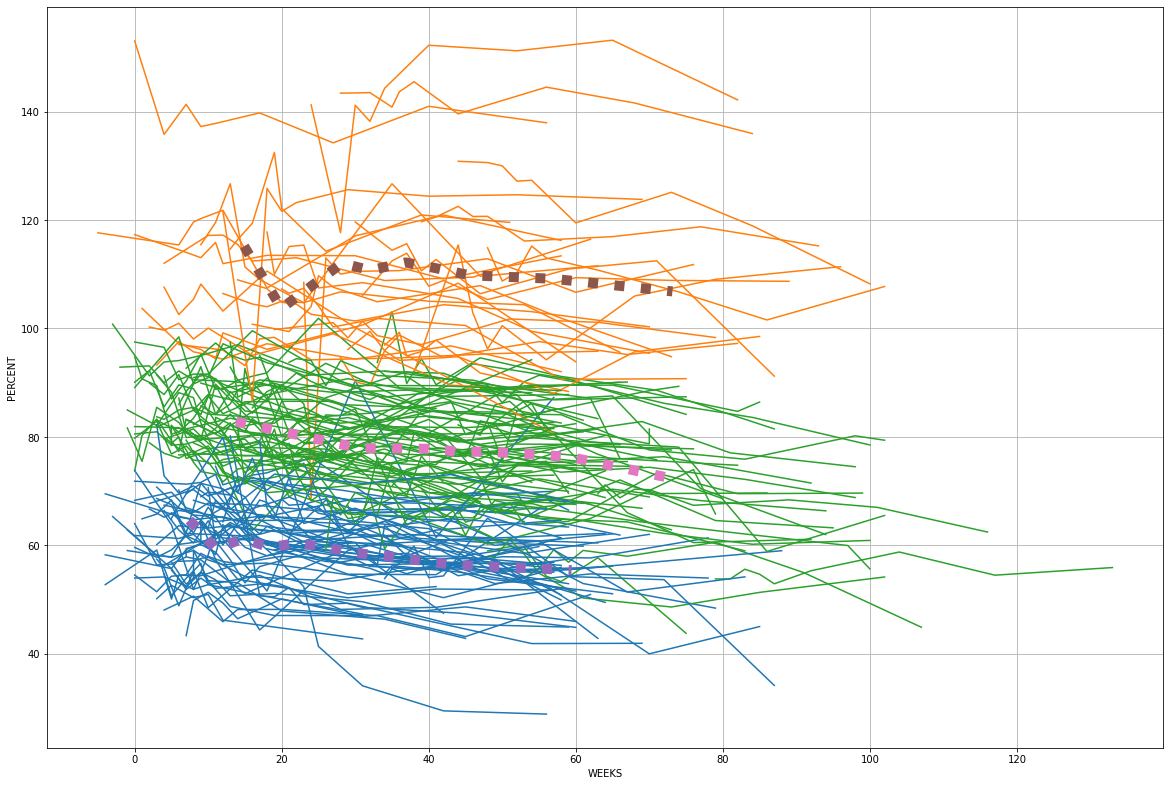

In [113]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 30

import matplotlib
colors = list(matplotlib.colors.TABLEAU_COLORS.items())

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
for pt_id, c in zip(df_train.Patient.unique(), pred):
  tmp_df = df_train[df_train.Patient == pt_id]
  ax.plot(tmp_df.Weeks, tmp_df.Percent, color=colors[c][1])


plt.plot(dba_c0.T[0],dba_c0.T[1], color=colors[4][1], linewidth=10, linestyle="dotted")
plt.plot(dba_c1.T[0],dba_c1.T[1], color=colors[5][1], linewidth=10, linestyle="dotted")
plt.plot(dba_c2.T[0],dba_c2.T[1], color=colors[6][1], linewidth=10, linestyle="dotted")
#plt.plot(dba_c3.T[0],dba_c3.T[1], color=colors[7][1], linewidth=10, linestyle="dotted")
ax.set_xlabel('WEEKS')
ax.set_ylabel('PERCENT')
ax.grid(True)
plt.show()